<a href="https://colab.research.google.com/github/prithwis/parashar21/blob/main/P21_45_06_SingleChart_Yogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://1.bp.blogspot.com/_5QlanosqxiQ/SXLOLTu7S7I/AAAAAAAAAm8/0r6C7lCxsic/S1600-R/p21-header-003.png) <br>


---



[Prithwis Mukerjee](http://www.yantrajaal.com) ||
Website - [Parashar21](https://parashar21.blogspot.com)<br>

Copyright (c) 2022, Prithwis Mukerjee All rights reserved.

This source code is licensed under the GNU GPL v3.0 -style license found in the LICENSE file in the root directory of this source tree.

#Rationale

Why MongoDB here? <br> <br>

Parashar21 was designed to cast horoscopes, convert the data in JSON format and then store the same in a MongoDB database. The Mongo query language was next used to filter out horoscopes that met certain criteria and then create human readable MS-Word documents for each selected horoscope. <br> <br>
In this notebook, our focus is a single horoscope chart but to reuse the considerable effort that has gone into the earlier effort, we are still storing the single chart in a MongdDB and then retrieving it for subsequent processing. This MongoDB may seem to be an additional overhead but actually it is not. Because checking to see if a chart meets certain criteria is no different from extracting the same from a database when it meets the same criteria. <br> <br>
This is particularly true when we have to search for different Yogs ( or complex conjuctions) <br> <br>
Also the report writing modules are based on the fact that the chart has been extracted from a MongoDB database and we are reusing the same modules.

#SetUp Environment

##Install Software

In [1]:
!pip -qq install pyswisseph                                 # https://stackoverflow.com/questions/64277506/pip-install-options-unclear

#!/usr/bin/python3 -m pip install "pymongo[srv]"
!apt install mongodb > /dev/null            # install local MongoDB server           
!service mongodb start                      # start Local MongoDB server instance

!pip -qq install python-docx                #https://python-docx.readthedocs.io/en/latest/



     |████████████████████████████████| 1.8 MB 27.2 MB/s 


 * Starting database mongodb
   ...done.
     |████████████████████████████████| 5.6 MB 26.9 MB/s 


##Install, import prerequisites

In [2]:
#Utility functions 
from pymongo import MongoClient
import pandas as pd
import dateutil
import json
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from datetime import datetime
from datetime import timedelta
import pytz

#import matplotlib.pyplot as plt
#import math


In [3]:
#Load p21 modules from github
!wget -O p21.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21.py                  # all global variables
!wget -O p21utils.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21utils.py        # large number of utility functions
!wget -O p21utilsR.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21utilsR.py 
!wget -O p21swe.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21swe.py            # Swiss Ephemeris functions
!wget -O p21YogInfo.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21YogInfo.py    # yog data 
# ---------------------------

!wget -O Saraswati.png -q https://github.com/prithwis/parashar21/raw/main/images/Saraswati02.png                 
!wget -O p21logo.png -q https://github.com/prithwis/parashar21/raw/main/images/p21logo-002-1.png                  

In [16]:
#!cat p21utils.py
import p21
import p21utils
import p21utilsR
import p21swe
import p21YogInfo
# ------------------------------------------------
# required for multiple imports of the same module
# ------------------------------------------------
import importlib
importlib.reload(p21)
importlib.reload(p21utils)
importlib.reload(p21utilsR)
importlib.reload(p21swe)
importlib.reload(p21YogInfo)

from p21YogInfo import  yogCond, yogText

imported p21
p21utils imported
p21utilsR imported
p21swe imported


In [5]:
#Download Swiss Ephemeris Files 
!wget -q http://www.astro.com/ftp/swisseph/ephe/seas_18.se1
!wget -q http://www.astro.com/ftp/swisseph/ephe/semo_18.se1
!wget -q http://www.astro.com/ftp/swisseph/ephe/sepl_18.se1
!mkdir ephe
!mv *.se1 ephe
#------------------------------
# Configure SWE with appropriate parameters
#
p21swe.C01_configSWE()

# Standalone database

We use a locally installed, temporary MongoDB to store and process the data


## Generate Data

In [6]:
#Read Birth Data from a file
import pandas as pd

!wget -O peopleData.csv -q https://raw.githubusercontent.com/prithwis/parashar21/main/data/Test5Data.txt # 5 Person Test Data


df0 = pd.read_csv('peopleData.csv')
df0.head()

,Gender,Voc1_Cat,Voc1_Det,Voc2_Cat,Voc2_Det,Voc3_Cat,Voc3_Det,DoB_Day,DoB_Mon,DoB_Year,DoB_Time,TZ_Off,TZ_OffHours,PoB_Lat,PoB_Lon,TZ_Name,TZ_Type,Name
0,M,Engineer,nil,Teacher,nil,PostGraduate,nil,15,10,1961,23:42,h5e30,5.5,22.57,88.37,IST,standard,person1
1,F,Author,nil,Homemaker,nil,PostGraduate,nil,19,12,1965,10:26,h5e30,5.5,22.57,88.37,IST,standard,person2
2,M,Engineer,nil,Teacher,nil,PostGraduate,nil,9,10,1990,23:09,h5e30,5.5,22.57,88.37,IST,standard,person3
3,F,Biologist,nil,Scientist,nil,PostGraduate,nil,12,9,1990,0:52,h5e30,5.5,22.87,88.37,IST,standard,person4
4,M,Politician,nil,Administrator,nil,nil,nil,17,9,1950,9:34,h5e30,5.5,23.48,72.36,IST,standard,NDModi


In [18]:
#Choose any one of the 5 persons 
#df.append(df0.iloc[1])
#df = df0.iloc[1].to_frame().T
df = pd.DataFrame(df0.iloc[2]).transpose()
df

,Gender,Voc1_Cat,Voc1_Det,Voc2_Cat,Voc2_Det,Voc3_Cat,Voc3_Det,DoB_Day,DoB_Mon,DoB_Year,DoB_Time,TZ_Off,TZ_OffHours,PoB_Lat,PoB_Lon,TZ_Name,TZ_Type,Name
2,M,Engineer,nil,Teacher,nil,PostGraduate,nil,9,10,1990,23:09,h5e30,5.5,22.57,88.37,IST,standard,person3


In [19]:
#%%time
# Converts date/time info into a detailed horoscope chart 
# Stores the same in a JSON file, to be inserted into a local MongoDB database

p21.ChartType = 'Rashi'                                 # one of ['Rashi','Navamsa']

writeFile =  open("peopleData.json", "w")  
for person in range(len(df)):
    try :
        personData =df.iloc[person]
        p21swe.C02_parsePersonData(personData)                  # split the data, extract required data into fields
                                                                # create skeleton chart json doc as p21.chart
        p21swe.C03_convertDates()                               # convert date, time of birth into universal time, calculate Ayanamsha
        p21swe.C04_calculateGrahaPositions()                    # calculate the Lon of each Graha along with Retrograde staus

                    #Horoscope is defined in terms of Natal Longitudes and Retrogrades
                    # for example
                    #GLon = {"La":98.5,"Su":178.9,"Mo":250.6,"Ma":196.2,"Me":193.2,"Ju":274.8,"Ve":153.8,"Sa":270.2,"Ra":122.1,"Ke":302.1}
                    #GRet = {"La":False,"Su":False,"Mo":False,"Ma":False,"Me":True,"Ju":False,"Ve":False,"Sa":False,"Ra":True,"Ke":True}

        p21swe.C05_buildGLonGRet()                              # create two json docs ( python dicts) to store Graha Lon and Ret status
                                                                # these are stored as global variables p21.GLon, p21.GRet
        p21utils.appendDict(p21.chart,p21.GLonRet)              # add Lon, Ret information to chart
        
        # ----------------------------------------
        p21utils.R11_LocateGrahaInRashi()
        
        p21utils.C10_DetermineBhavs()                           # determine Houses for person
        p21utils.appendDict(p21.chart,p21.BhavNBhavA)           # add BhavN, BhavA information to chart   
         
        # ----------------------------------------    
        p21utils.C11_DetermineLord()                            # determine Lords of Bhavs
        p21utils.appendDict(p21.chart,p21.LordInfo)             #  add information on Lords   

        p21utils.C12_BhavOfGraha_Lord()
        p21utils.appendDict(p21.chart,p21.BhavOfGraha_LordInfo) #  add information on Bhav Residency of Graha and Lords  
        
        
        p21utils.C21_DeterminePositions()
        p21utils.appendDict(p21.chart,p21.Positions)            #  add information on Graha / Lord POSITIONS  

        p21utils.C31_DetermineAspects()
        p21utils.appendDict(p21.chart,p21.Aspects)              #  add information on Graha / Lord ASPECTS  

        p21utils.C41_DetermineConjuncts()           
        p21utils.appendDict(p21.chart,p21.Conjuncts)            #  add information on Graha / Lord Conjuncts
    except :
        print('error on record ', person)
    else :
        #insert_result = kollection.insert_one(p21.chart)        # insert one json doc, chart to database
        #insert_result.acknowledged                              # Confirms that insert is successful
                                                                 # Bypassing insertion into MongoDB will make processing much faster
        json.dump(p21.chart, writeFile)                          # Storing chart data as JSON file
    finally:
        if ( person % 1000 ) == 0:
            print(person, "records processed")
    
writeFile.close()


0 records processed


##Load the SINGLE chart into the local MongoDB

In [20]:
!mongoimport --db parashar21Local --collection khona21Test --drop --file peopleData.json

2022-09-15T07:49:57.422+0000	connected to: localhost
2022-09-15T07:49:57.422+0000	dropping: parashar21Local.khona21Test
2022-09-15T07:49:57.454+0000	imported 1 document


In [21]:
mongoURI = "mongodb://localhost:27017/"                               # for remote server
client = MongoClient(mongoURI)

db = client.parashar21Local
#pd.DataFrame(list(db.list_collections()))

In [22]:
kollection = db.khona21Test                   # Set the collection to work with
#kollection = db.khona21                   # Set the collection to work with
totalCharts = kollection.count_documents({})
dbSize = db.command( {"dbStats": 1, "scale": 1024 } )['dataSize']
print(totalCharts, ' documents,',round(dbSize,2), " KB data")

1  documents, 3.57  KB data


#Report Generation Function
Please note that the generated report MS Office doc format **will be stored in the Colab VM drive** and needs to be downloaded to local machine for viewing

In [23]:
def genSingleChartReport(ChartStyle):
      
    chartData = chart.iloc[0]
    RepID = chart.iloc[0]['pid']['name']
    now = datetime.now(pytz.timezone('Asia/Kolkata'))
    fileName = 'p21_'+RepID+'_'+ChartStyle+'_'+now.strftime("%H%M%S")+'.doc'

    #print(chartData)
    # ---------------------------------------------------------
    #p21utilsR.R01_CreateReportDoc(curQueryStr, printStatus)        # Creates MS Word Doc called p21.document for MULTIPLE charts
    p21utilsR.R01A_CreateReportDoc(RepID)                           # Creates MS Word Doc called p21.document for SINGLE chart
    # ----------------------------------------------------------
    
    p21utilsR.R511_parseChartData(chartData)                # Break up database data into useful pieces
                                                            # Creates two primary dicts, GLon, GRet
    for ctype in ['Rashi','Navamsa']:
        p21.ChartType = ctype
        p21utils.R11_LocateGrahaInRashi()   # Converts Graha Long to Rashi positions
                                            # Rashi Num as well as Rashi name
        if ChartStyle == 'Bengal':
            p21utilsR.R12B_drawChart_Bengal()    # Draw Chart in Bengal style
        if ChartStyle == 'South':
            p21utilsR.R12B_drawChart_South()    # Draw Chart in South style
        if ChartStyle == 'North':
            p21utilsR.R12B_drawChart_North()    # Draw Chart in North style
        
    p21utilsR.R512_FormatPage('SingleChart')                  # this is where the details of the chart are printed out
    
    # ------------------------------------
    p21.document.save(fileName)
    


#Retrieve Charts 
Based on selective queries <br>
All output messages suppressed <br>
Reports will be available as DOC files in the VM drive <br>
Please specify style of report, 'Bengal', 'North' or 'South' while calling the report generation routine <br>
genSampleReport('Bengal',Sample = False), 


## Retrieve, Display and Analyse the SingleChart chart

In [24]:
#selCond = {'pid.name': {'$eq': 'person3'}}               # Single Person
#selCond = {"pid.name": {"$regex":"^per"}}                # Name starting with per
selCond = {}                                              # All Charts, but since we have only one chart, we get that chart only
chart = pd.DataFrame(list(kollection.find(selCond,p21.selCols)))
chart.iloc[0]['pid']['name']


'person3'

In [25]:
#Find Yogs in Chart
yogList = ['BudhAditya','BudhAdityaNR', 'Gajakesari', 'Rajyog', 'ChandraMangal2','DhanYog']
p21.yogsFound = []
for yogName in yogList:
    selCond = yogCond[yogName]
    count = len(list(kollection.find(yogCond[yogName],{"pid.name" : 1,"_id":0})))
    if count > 0:
        p21.yogsFound.append(yogName)
    print(yogName, count )
print(p21.yogsFound)    

BudhAditya 1
BudhAdityaNR 1
Gajakesari 0
Rajyog 0
ChandraMangal2 0
DhanYog 1
['BudhAditya', 'BudhAdityaNR', 'DhanYog']


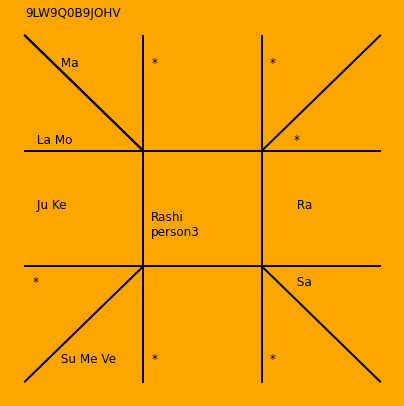

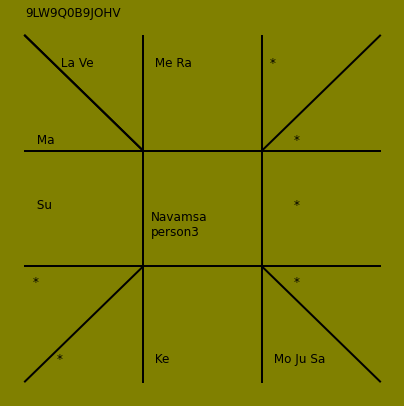

In [26]:
#%%capture
genSingleChartReport('Bengal')

#Testing Stuff

In [26]:
#%%capture
from p21YogInfo import  yogCond, yogText
yogName = 'BudhAditya'
#print(yogCond[yogName])
selCond = yogCond[yogName]
#df = pd.DataFrame(list(kollection.find(yogCond[yogName],p21.selCols)))
selCols = {"pid.name" : 1,"_id":0}
name = list(kollection.find(yogCond[yogName],selCols))
#genYogReport(yogText[yogName],'Bengal')
#name
len(list(kollection.find(yogCond[yogName],selCols)))

1

In [14]:
from p21YogInfo import  yogCond, yogText
yogList = ['BudhAditya','BudhAdityaNR', 'Gajakesari', 'Rajyog', 'ChandraMangal2','DhanYog']
p21.yogsFound = []
for yogName in yogList:
    selCond = yogCond[yogName]
    count = len(list(kollection.find(yogCond[yogName],{"pid.name" : 1,"_id":0})))
    if count > 0:
        p21.yogsFound.append(yogName)
    print(yogName, count )
print(p21.yogsFound)    
    
    

BudhAditya 1
BudhAdityaNR 0
Gajakesari 0
Rajyog 0
ChandraMangal2 0
DhanYog 1
['BudhAditya', 'DhanYog']
